In [26]:
import os
import sunpy.map
import matplotlib
import numpy as np
import plotly.io as pio
from matplotlib import pyplot as plt

import prepare_data
import run_detection
import plot_detection

pio.renderers.default = 'vscode'
%matplotlib inline

# Data Inspection

## Prepare Data

Configure File Paths

In [27]:
DATA_DIR = 'assets/'

ALL_HE_DIR = DATA_DIR + 'All_He/'
SELECT_HE_DIR = DATA_DIR + 'Selected_He/'

ALL_MAG_DIR = DATA_DIR + 'All_Mag/'
SELECT_MAG_DIR = DATA_DIR + 'Selected_Mag/'

ALL_EUV_DIR = DATA_DIR + 'All_EUV/'
SELECT_EUV_DIR = DATA_DIR + 'Selected_EUV/'

NSO_INPUT_DIR = DATA_DIR + 'NSO_Input/'
NSO_SINGLE_DIR = DATA_DIR + 'NSO_Output/single/'
NSO_MERGED_DIR = DATA_DIR + 'NSO_Output/merged/'

OUTPUT_DIR = DATA_DIR + 'Output/'
SINGLE_MAPS_DIR = OUTPUT_DIR + 'Single_Maps/'

REPROJECT_MAG_SAVE_DIR = OUTPUT_DIR + 'Reprojected_Mag/'

DICT_DATE_STR_FORMAT = '%Y_%m_%d__%H_%M'

Specify date range and file path for saved ensemble maps

In [28]:
# ENSEMBLE_MAPS_DIR = OUTPUT_DIR + 'Ensemble_Maps_v0_3/'
# ENSEMBLE_MAPS_DIR = OUTPUT_DIR + 'Band_Pass/'
# ENSEMBLE_MAPS_DIR = OUTPUT_DIR + 'Rescale/'
ENSEMBLE_MAPS_DIR = OUTPUT_DIR + 'Rescale_Center/'

ENSEMBLE_MAP_SAVE_DIR = ENSEMBLE_MAPS_DIR + 'Ensemble_Map_Files/'

# # GMU period early in Solar Cycle 24
# date_range = ('2012_04_01__00_00', '2012_09_01__00_00')
# ENSEMBLE_MAP_IMAGE_DIR = ENSEMBLE_MAPS_DIR + '2012_04_2012_08/'

# June of GMU period early in Solar Cycle 24
date_range = ('2012_06_01__00_00', '2012_07_01__00_00')
ENSEMBLE_MAP_IMAGE_DIR = ENSEMBLE_MAPS_DIR + '2012_06/'

# # Select few dates for analysis
# date_range = None
# ENSEMBLE_MAP_IMAGE_DIR = ENSEMBLE_MAPS_DIR + 'Selected_Maps/'

# All dates
# date_range = ('2000_01_01__00_00', '2020_01_01__00_00')

# CR 2136
# date_range = ('2013_04_01__00_00', '2013_06_01__00_00')

# CR 2151
# date_range = ('2014_06_01__00_00', '2014_06_30__00_00')

Rename Data

In [27]:
# Delete all gzipped files after renaming
remove_gzip = True

# Rename all He FITS files to include observation date in title
prepare_data.rename_dir(ALL_HE_DIR, remove_gzip)

# Rename all magnetogram FITS files to include observation date in title
prepare_data.rename_dir(ALL_MAG_DIR, remove_gzip)

# Rename all EUV FITS files to include observation date in title
prepare_data.rename_dir(ALL_EUV_DIR, remove_gzip)

Extract Data from File System

In [29]:
# Extract He I observation datetimes from FITS files
HE_DATE_LIST = prepare_data.get_fits_date_list(
    date_range, ALL_HE_DIR, SELECT_HE_DIR
)

# Extract magnetogram datetimes from 6302l FITS files
MAG_DATE_LIST = prepare_data.get_fits_date_list(
    date_range, ALL_MAG_DIR, SELECT_MAG_DIR
)

# Extract EUV datetimes from FITS files
EUV_DATE_LIST = prepare_data.get_fits_date_list(
    date_range, ALL_EUV_DIR, SELECT_EUV_DIR
)

# Extract NSO pre-processed EQW arrays from NSO FITS files
NSO_EQW_DICT = prepare_data.extract_nso_eqw(NSO_SINGLE_DIR)
NSO_EQW_DATE_LIST = list(NSO_EQW_DICT.keys())
NSO_EQW_DATE_LIST.sort()

# Extract NSO estimated CH Carrington maps from NSO FITS files
CH_MAP_DICT = prepare_data.extract_nso_ch_maps(NSO_MERGED_DIR)
CH_MAP_LIST = list(CH_MAP_DICT.keys())
CH_MAP_LIST.sort()

## EUV Download

Automatic

In [5]:
from datetime import datetime, timedelta
DICT_DATE_STR_FORMAT = '%Y_%m_%d__%H_%M'

# Dates for which to download EUV observations
download_euv_dates = HE_DATE_LIST

# Identify missing dates
available_datetimes = [datetime.strptime(date_str, DICT_DATE_STR_FORMAT).date()
                       for date_str in HE_DATE_LIST]
days_in_period = (available_datetimes[-1] - available_datetimes[0]).days
all_period_dates = set(available_datetimes[0] + timedelta(num_days)
                       for num_days in range(days_in_period))
missing_dates = all_period_dates - set(available_datetimes)

# Missing datetime strings shifted to noon
missing_date_str_list = [
    datetime.strftime(missing_date, DICT_DATE_STR_FORMAT)
    for missing_date in missing_dates
]
missing_date_str_list = [
    missing_date_str[:12] + '16_00'
    for missing_date_str in missing_date_str_list
]

# Add missing datetimes
download_euv_dates.extend(missing_date_str_list)
download_euv_dates.sort()

In [10]:
download_euv_dates = download_euv_dates[97:98]

In [11]:
prepare_data.download_euv(download_euv_dates, EUV_DATE_LIST,
                          download_dir=ALL_EUV_DIR, hr_window=3)

1 Datetimes for which to Download EUV:
2012_07_05__16_00 	
Fetching data for 2012_07_05__16_00... 1/1


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia_lev1_193a_2012_07_05t13_00_06_84z_image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

Downloaded EUV Observation Datetimes:
2012_07_05__16_00 	

Manual

In [ ]:
import astropy.units as u
from datetime import datetime, timedelta
from sunpy.net import Fido, attrs as a


date_str = '2012_05_12__18_28'
hr_window = 1

center_date = datetime.strptime(date_str, DICT_DATE_STR_FORMAT)
        
min_date = center_date - timedelta(hours=hr_window)
max_date = center_date + timedelta(hours=hr_window)

result = Fido.search(
    a.Time(min_date, max_date),
    a.Instrument.aia, a.Wavelength(193*u.angstrom),
    a.Sample(30*u.minute), 
)
result

In [ ]:
row_num = 2
download_dir = ALL_EUV_DIR

Fido.fetch(result[:, row_num], path=download_dir + '{file}')

## Available Data

In [ ]:
print('Available Datetimes for He I Observations:')
prepare_data.display_dates(HE_DATE_LIST)

In [ ]:
print('Available Datetimes for Magnetograms:')
prepare_data.display_dates(MAG_DATE_LIST)

In [ ]:
print('Available Datetimes for EUV Observations:')
prepare_data.display_dates(EUV_DATE_LIST)

In [ ]:
print('Available Datetimes for NSO Pre-Processed He I Observations:')
prepare_data.display_dates(NSO_EQW_DATE_LIST)

In [ ]:
print('Available Carrington Rotation for NSO Coronal Hole Maps:')
prepare_data.display_crs(CH_MAP_LIST)

# Magnetograms & EUV

In [ ]:
smooth_size_percent = 10

for eqw_date_str in HE_DATE_LIST:

    mag_date_str = prepare_data.get_nearest_date_str(
        MAG_DATE_LIST, selected_date_str=eqw_date_str
    )
    euv_date_str = prepare_data.get_nearest_date_str(
        date_str_list=EUV_DATE_LIST, selected_date_str=eqw_date_str
    )

    eqw_map = prepare_data.get_solis_sunpy_map(SELECT_HE_DIR + eqw_date_str + '.fts')
    mag_map = prepare_data.get_solis_sunpy_map(SELECT_MAG_DIR + mag_date_str + '.fts')
    euv_map = sunpy.map.Map(SELECT_EUV_DIR + euv_date_str + '.fts')

    # Process magnetogram
    smoothed_mag_map = prepare_data.get_smoothed_map(mag_map, smooth_size_percent)

    fig = plt.figure(figsize=(18, 5))

    ax = fig.add_subplot(131, projection=eqw_map)
    eqw_map.plot(axes=ax, vmin=-100, vmax=100, title=eqw_date_str)

    ax = fig.add_subplot(132, projection=mag_map)
    mag_map.plot(axes=ax, vmin=-50, vmax=50, title=mag_date_str)
    plot_detection.plot_map_contours(ax, smoothed_mag_map)
    
    ax = fig.add_subplot(133, projection=euv_map)
    euv_map.plot(axes=ax, title=euv_date_str)

Differentially Rotated Maps

In [ ]:
eqw_date = HE_DATE_LIST[3]
mag_date = MAG_DATE_LIST[4]

he_fits = SELECT_HE_DIR + eqw_date + '.fts'
eqw_map = prepare_data.get_solis_sunpy_map(he_fits)

mag_fits = SELECT_MAG_DIR + mag_date + '.fts'
mag_map = prepare_data.get_solis_sunpy_map(mag_fits)


fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection=mag_map)
mag_map.plot(axes=ax1, vmin=-50, vmax=50,
               title=f'Original: {mag_map.date}')

smoothed_map = prepare_data.get_smoothed_map(mag_map, smooth_size_percent=10)
plot_detection.plot_map_contours(ax1, smoothed_map)

reprojected_map = prepare_data.get_reprojected_map(
   input_map=mag_map, target_map=eqw_map
)

ax2 = fig.add_subplot(122, projection=reprojected_map)
reprojected_map.plot(axes=ax2, vmin=-50, vmax=50,
                     title=f'Reprojection: {reprojected_map.date}')

reprojected_smooth_map = prepare_data.get_reprojected_map(
   input_map=smoothed_map, target_map=eqw_map
)
plot_detection.plot_map_contours(ax2, reprojected_smooth_map)

# NSO Data

## Input Level 2 Products: **Stage/Level2/**

10830i equivalent width: **svsm_e3100_S2_yyyymmdd_hhmm.fts.gz**

10830i intensity: **svsm_i3000_S2_yyyymmdd_hhmm.fts.gz**

6302l magnetogram: **svsm_m1100_S2_yyyymmdd_hhmm.fts.gz**

6302l intensity: **svsm_i1000_S2_yyyymmdd_hhmm.fts.gz**

SIMPLE  =                    T / Written by IDL:  Sat Jan 17 06:46:16 2015      
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                 2048 / Length of data axis 1 (columns)                
NAXIS2  =                 2048 / Length of data axis 2 (rows)                   
EXTEND  =                    F / This file may contain extensions (T/F)         
COMMENT                                                                         
COMMENT ______________________ FITS File Content Keywords ______________________
COMMENT                                                                         
ORIGIN  = 'National Solar Observatory Integrated Synoptic Program (NISP)'       
DATE    = '2015-01-17T13:46:16'/ [YYYY-MM-DDThh:mm:ss] UTC file creation time   
VERSION = '6.4     '           / Data product version number                    
IMTYPE  = '6301.5 Longitudin

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]

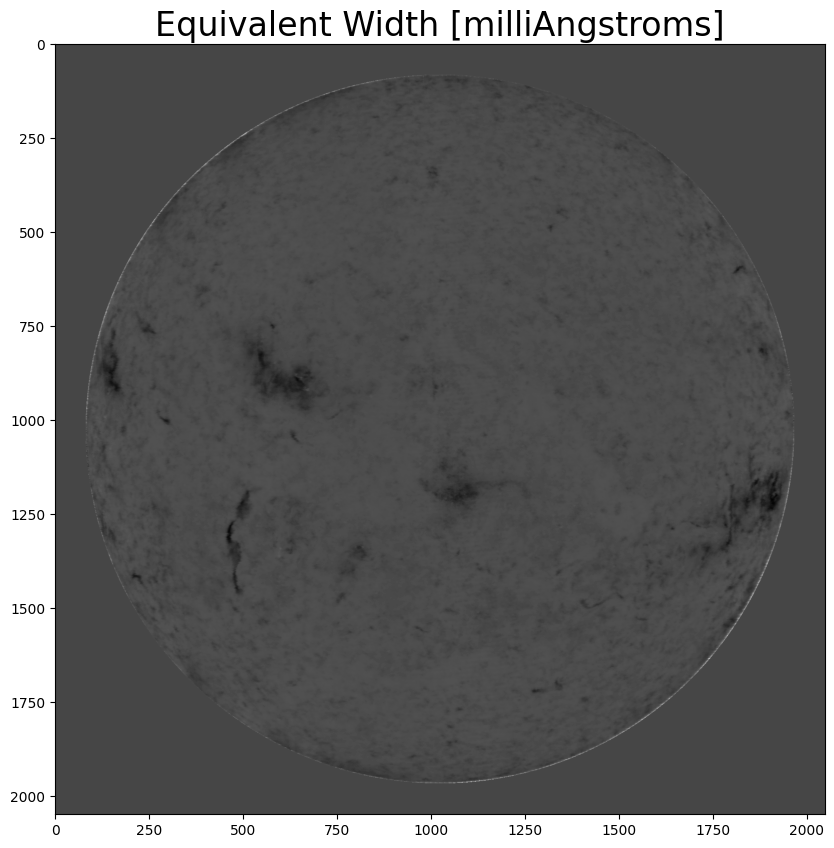

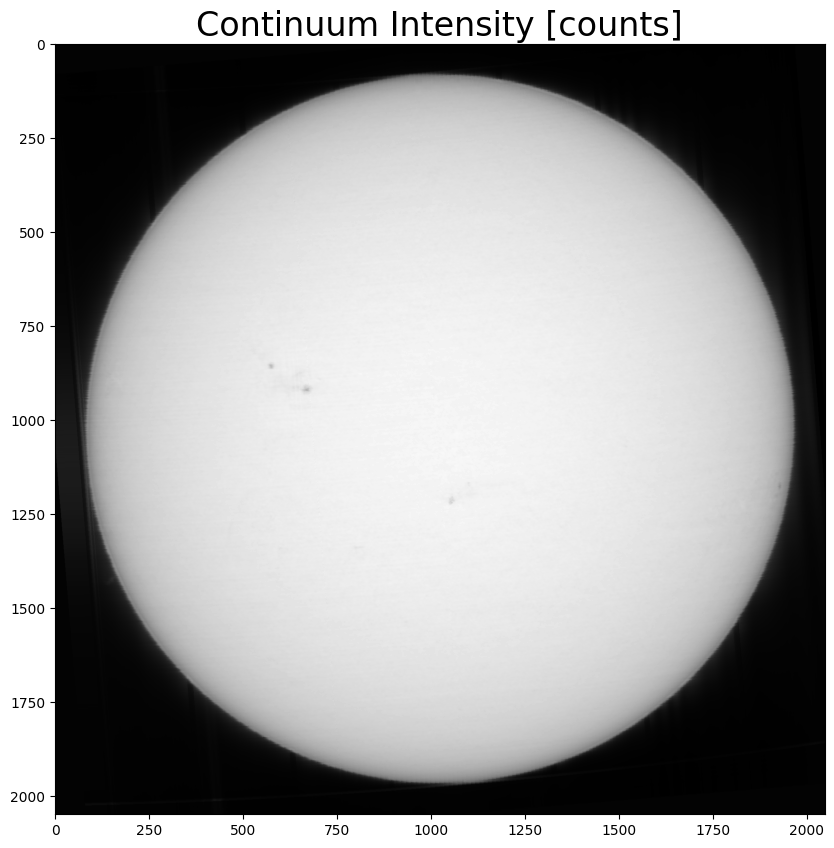

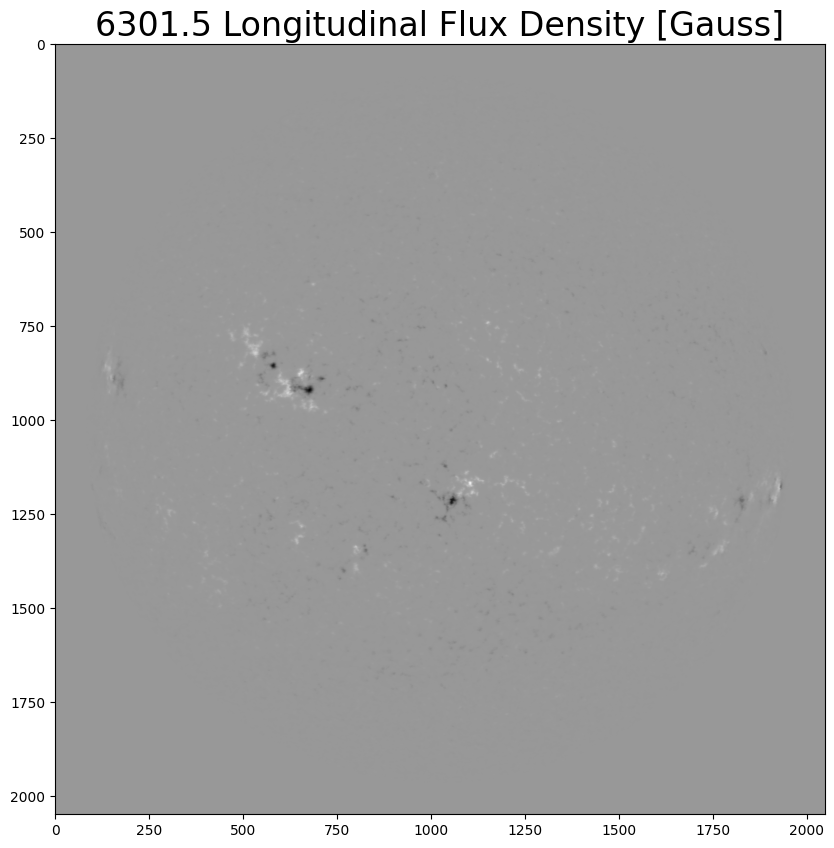

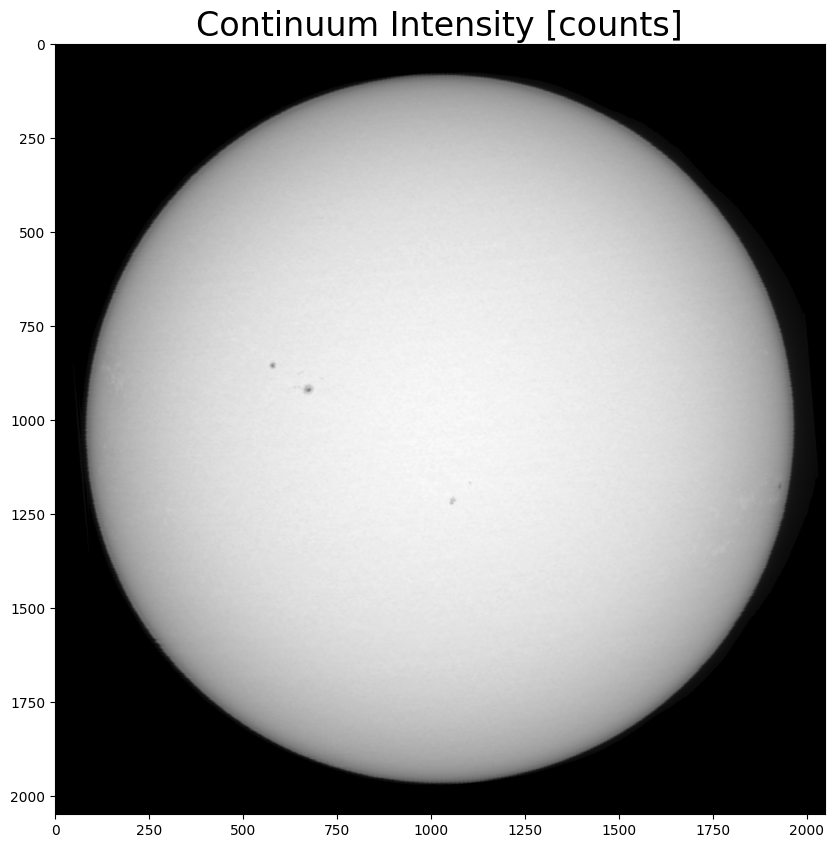

In [13]:
raw_he_eqw_fits_path = NSO_INPUT_DIR + 'svsm_e3100_S2_20140626_1419.fts'

raw_he_intensity_fits_path = NSO_INPUT_DIR + 'svsm_i3000_S2_20140626_1419.fts'

raw_magnetogram_fits_path = NSO_INPUT_DIR + 'svsm_m1100_S2_20140626_1444.fts'

raw_mag_intensity_fits_path = NSO_INPUT_DIR + 'svsm_i1000_S2_20140626_1444.fts'

im_list = plot_detection.plot_raw_fits_content(
    raw_he_eqw_fits_path, header_list=['IMTYPE'],
    # print_header=True
)
plot_detection.plot_raw_fits_content(
    raw_he_intensity_fits_path, header_list=['IMTYPE'],
    # print_header=True
)
plot_detection.plot_raw_fits_content(
    raw_magnetogram_fits_path, header_list=['IMTYPE'],
    print_header=True
)
plot_detection.plot_raw_fits_content(
    raw_mag_intensity_fits_path, header_list=['IMTYPE'],
    # print_header=True
)

## Output Level 3 Products: **Stage/Level3/**
He I EqW Maps List: **hDataList.txt**
- 'Text list of available 10830 He EqW low-res sine-latlon heliographic maps'
- Produced by **mk_datalist**
  - Args: heliographic He I EqW maps

Magnetogram Maps List: **mDataList.txt**
- 'Text list of available 6301.5 low-res sine-latlon heliographic maps'
- Produced by **mk_datalist**
  - Args: heliographic magnetograms

CH Maps List: **oDataList.txt**
- 'Text list of available 10830 solar wind source sine-latlon heliographic maps'
- Produced by **mk_datalist**
  - Args: heliographic CH maps

Carrington Rotation CH Images
- '10830 solar wind sine-latlon daily synoptic map plots'
- High-Res: **chsh.jpg**
- Med-Res: **chsm.jpg**
- Low-Res: **chsl.jpg**
- Produced by **plot_lev3_map**
  - Args: 1 carrington rotation CH map, CH maps list

Unincluded He I Observation Image?: **svsm_o10mr_S3_{yyyymmdd}_{hhmm}.jpg**
- Produced by **mk_obsimg**
  - Args: 1 sky frame disk CH map, CH maps list

#### Single Maps: **../single/{yyyy}/**

Sine-LatLon He I EQW: **svsm_e31hr_B3_{yyyymmdd}_{hhmm}.fts.gz**
- '10830 He EqW high-res sine-latlon heliographic map'
- Produced by **mk_synimg**
  - Args: L2 He I EQW file, L2 He I continuum intensity file

LatLon He I EQW: **svsm_e31lr_L3_{yyyymmdd}_{hhmm}.fts.gz**
- '10830 He EqW low-res latlon heliographic map'
- Produced by **mk_synimg**
  - Args: L2 He I EQW file, L2 He I continuum intensity file

Sine-LatLon Magnetogram: **svsm_m11hr_B3_{yyyymmdd}_{hhmm}.fts.gz**
- '6301.5 high-res sine-latlon heliographic map'
- Produced by **mk_synimg**
  - Args: L2 magnetogram file, L2 6302l magnetogram intensity file

LatLon Magnetogram: **svsm_m11lr_L3_{yyyymmdd}_{hhmm}.fts.gz**
- '6301.5 low-res latlon heliographic map'
- Produced by **mk_synimg**
  - Args: L2 magnetogram file, L2 6302l magnetogram intensity file

Sine-LatLon CH Map: **svsm_o1083_B3_{yyyymmdd}_{hhmm}.fts.gz**
- '10830 solar wind source sine-latlon heliographic map'
- Produced by **mk_holeimg**
  - Args: processed He I EqW, He I EqW maps list, processed magnetogram, magnetogram maps list

Sky Frame Disk CH Map: **svsmgo1083_B3_{yyyymmdd}_{hhmm}.fts.gz**
- '10830 solar wind source sky frame heliocentric map'
- Produced by **mk_dchimg**
  - Args: 1 disk CH map, disk CH maps list

SIMPLE  =                    T / Written by IDL:  Tue Aug 16 09:43:17 2022      
BITPIX  =                  -32 / IEEE single precision floating point           
NAXIS   =                    3 /                                                
NAXIS1  =                  900 /                                                
NAXIS2  =                  900 /                                                
NAXIS3  =                    3 /                                                
DATATYPE= 'REAL*4  '           /Type of data                                    
DATE    = '2022-08-16'         /                                                
TELESCOP= 'NSO-KPST'           /                                                
INSTRUME= 'VSM     '           /                                                
OBS-SITE= 'Kitt Peak'          /                                                
EPH_B0  =        2.34902678944 / Solar lat. of obs. disk centr (deg)            
EPH_L0  =        18.91329272

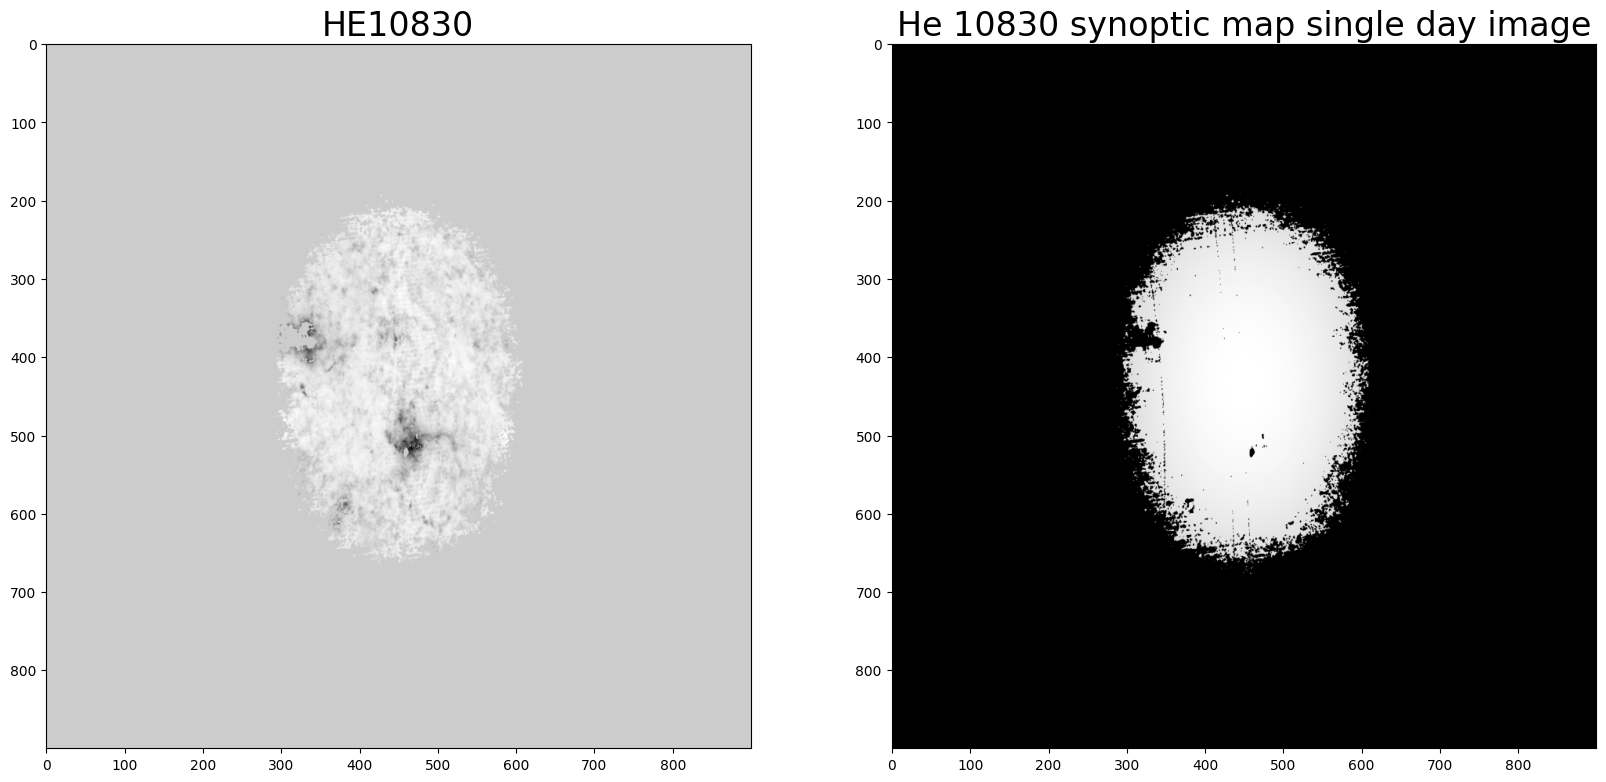

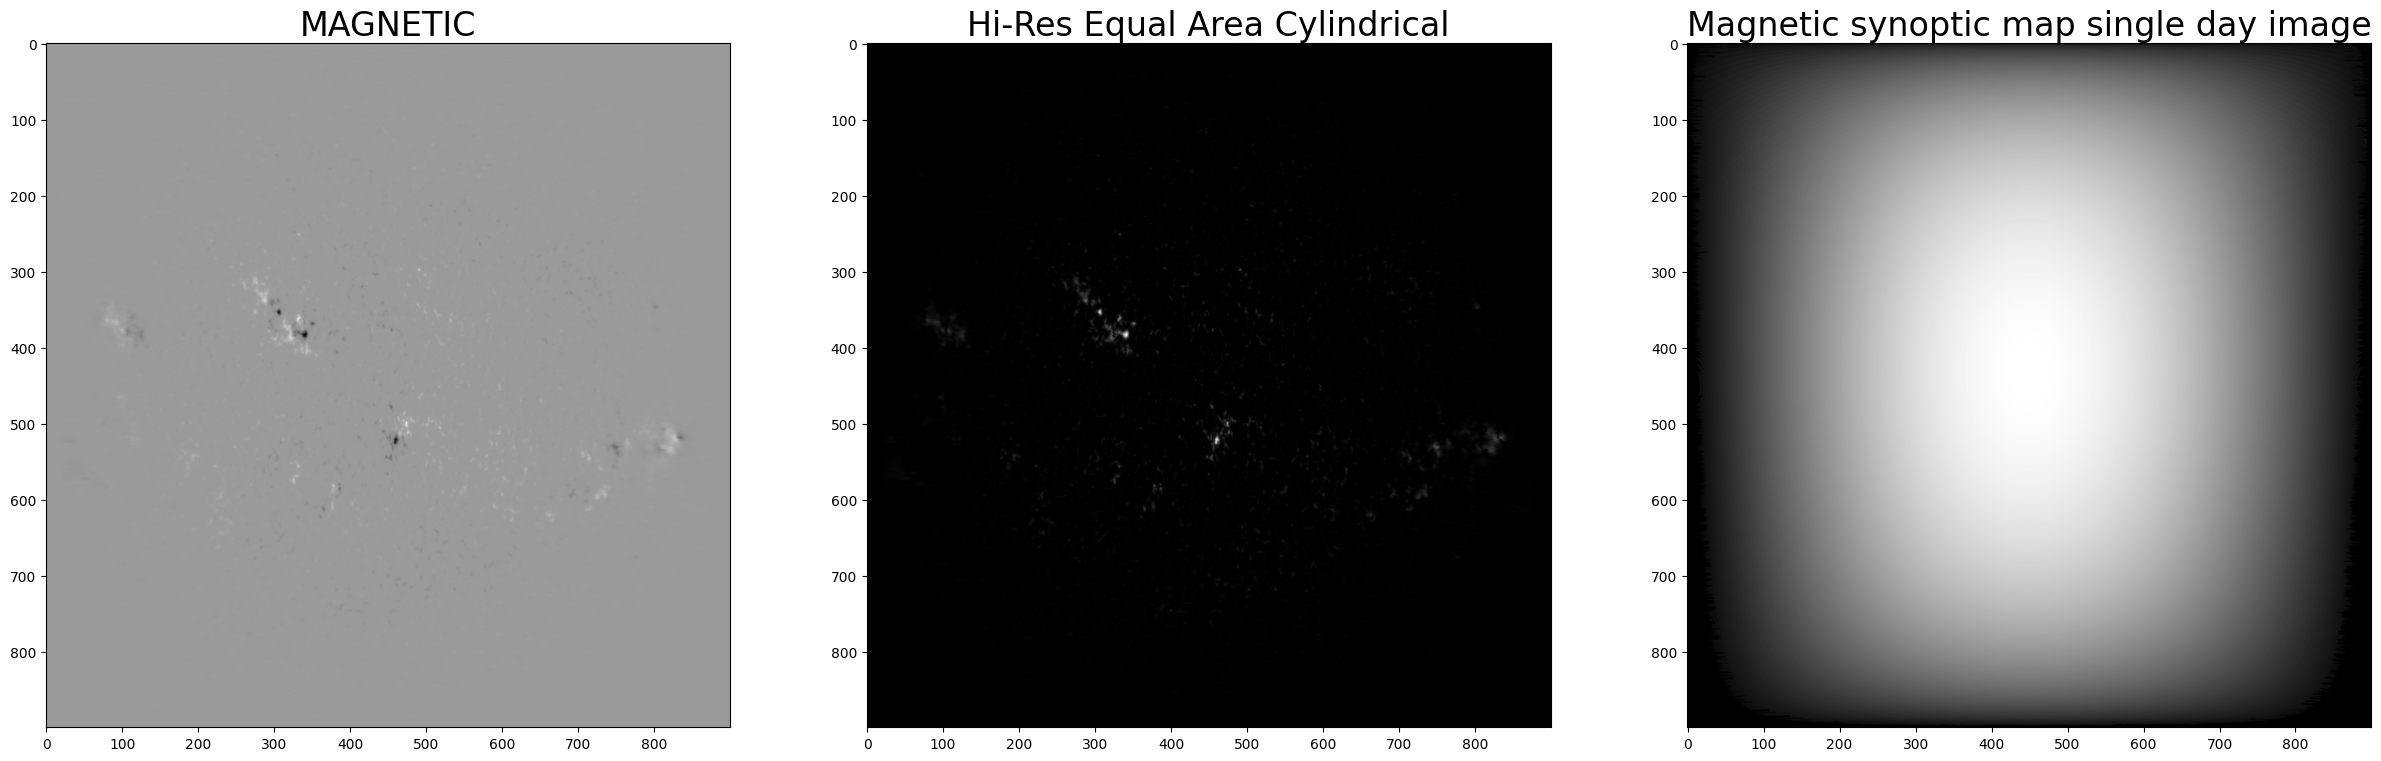

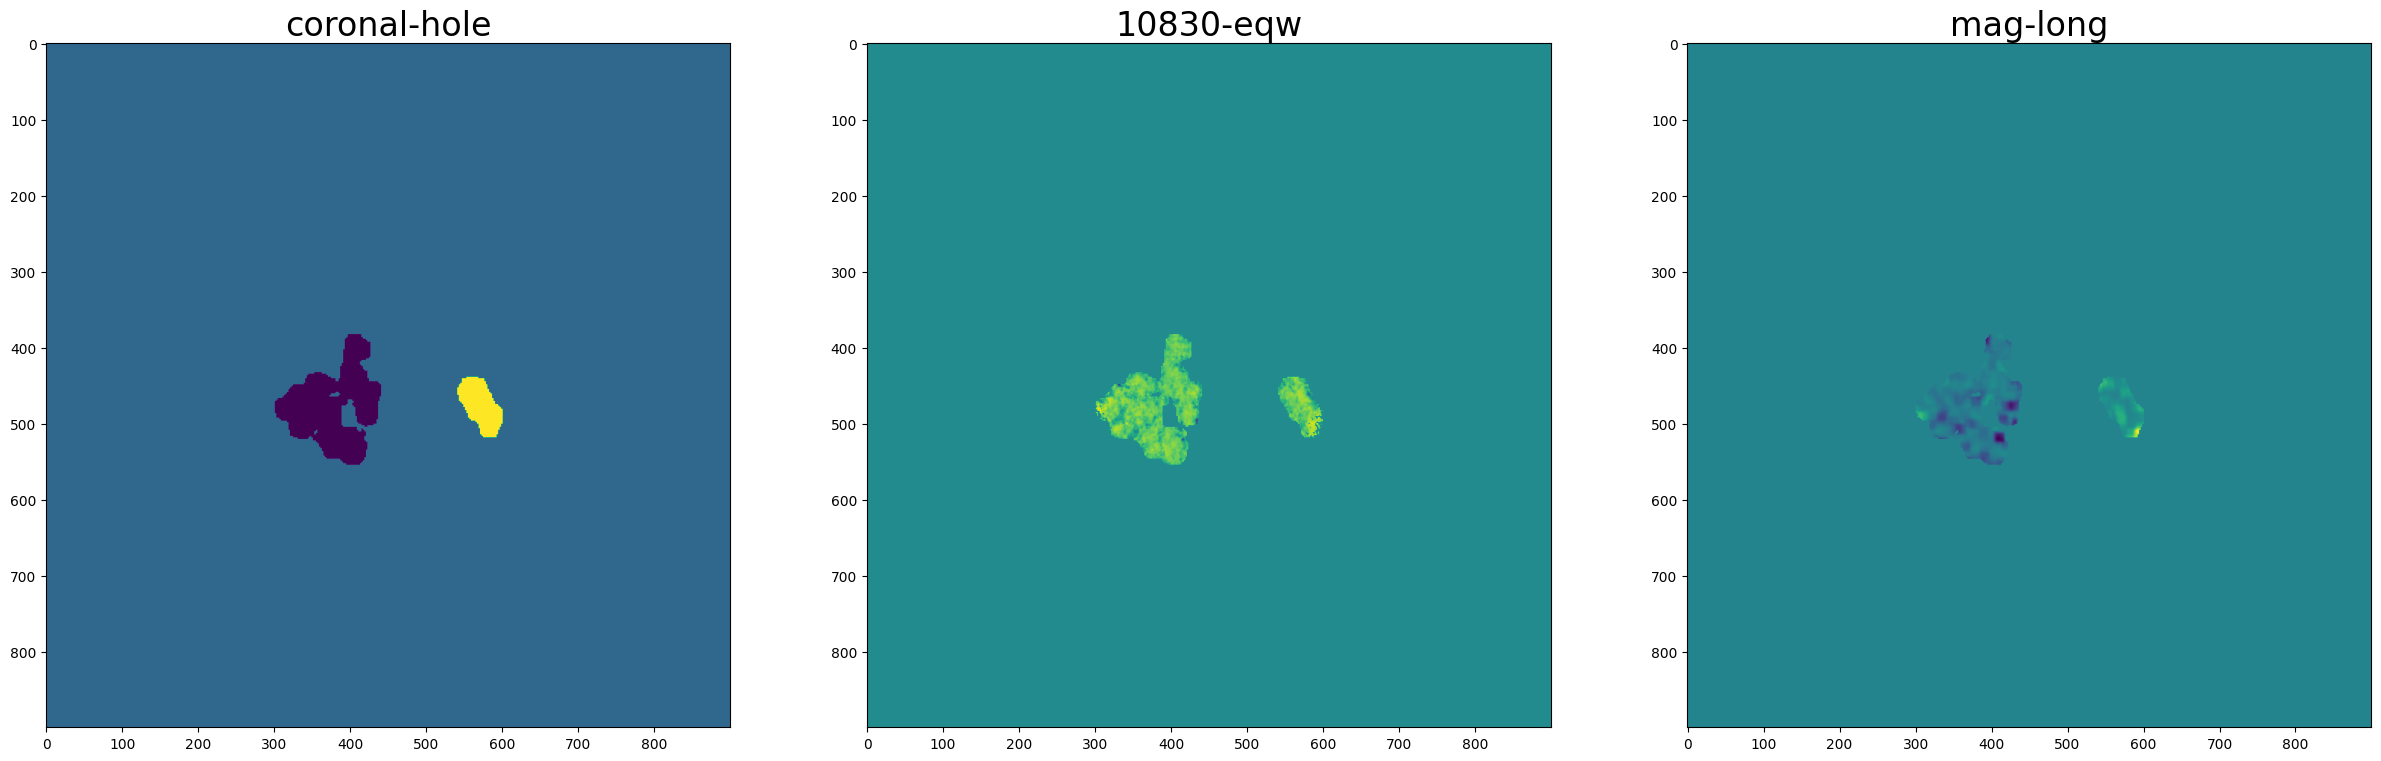

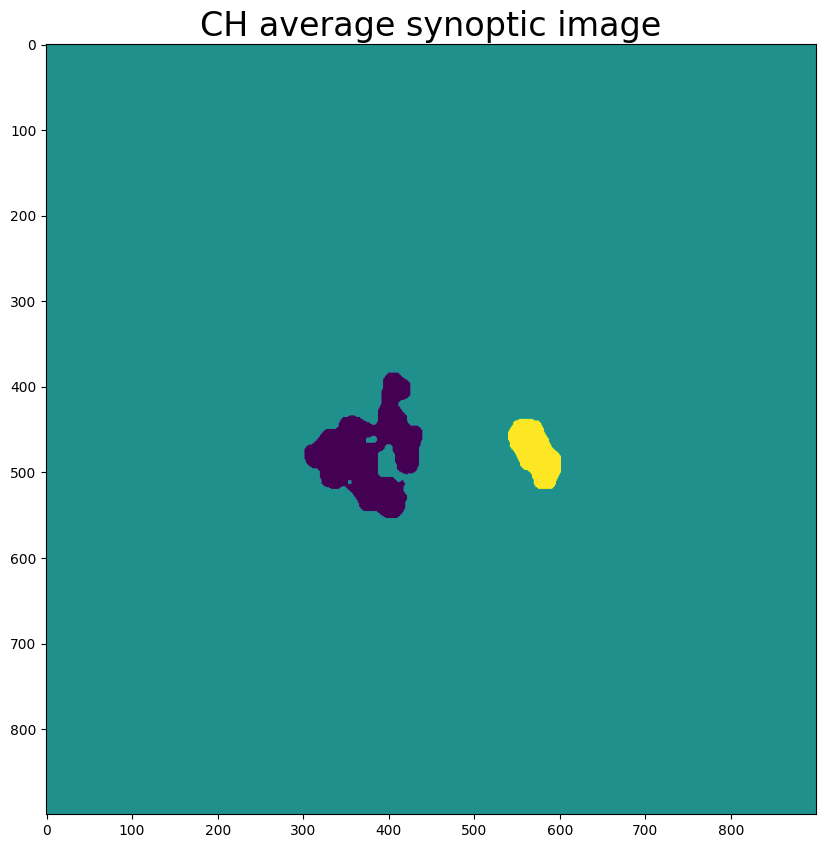

In [22]:
# he_eqw_fits_path = NSO_SINGLE_DIR + 'svsm_e31hr_B3_20140606_1746.fts'
he_eqw_fits_path = NSO_SINGLE_DIR + 'svsm_e31hr_B3_20140626_1419.fts'
# he_eqw_fits_path = NSO_SINGLE_DIR + 'svsm_e31lr_L3_20140626_1419.fts'

# mag_fits_path = NSO_SINGLE_DIR + 'svsm_m11hr_B3_20140606_1605.fts'
mag_fits_path = NSO_SINGLE_DIR + 'svsm_m11hr_B3_20140626_1444.fts'

# E: Empty file
# E ch_fits_map = NSO_SINGLE_DIR + 'svsm_o1083_B3_20140601_1836.fts'
# E ch_fits_map = NSO_SINGLE_DIR + 'svsm_o1083_B3_20140603_1704.fts'
# E ch_fits_map = NSO_SINGLE_DIR + 'svsm_o1083_B3_20140606_1755.fts'
# E ch_fits_map = NSO_SINGLE_DIR + 'svsm_o1083_B3_20140612_1438.fts'
# E ch_fits_map = NSO_SINGLE_DIR + 'svsm_o1083_B3_20140620_1711.fts'
ch_fits_map = NSO_SINGLE_DIR + 'svsm_o1083_B3_20140626_1428.fts'

# E sky_ch_fits_path = NSO_SINGLE_DIR + 'svsmgo1083_B3_20140606_1755.fts'
sky_ch_fits_path = NSO_SINGLE_DIR + 'svsmgo1083_B3_20140626_1428.fts'

plot_detection.plot_raw_fits_content(
    he_eqw_fits_path, header_list=['IMTYPE', 'COMMENT2'],
    cmaps=[plt.cm.gray, plt.cm.gray],
    # print_header=True
)
plot_detection.plot_raw_fits_content(
    mag_fits_path, header_list=['IMTYPE', 'COMMENT1', 'COMMENT2'],
    cmaps=[plt.cm.gray, plt.cm.gray, plt.cm.gray],
    # print_header=True
)
plot_detection.plot_raw_fits_content(
    ch_fits_map, header_list=['IMGTYP01', 'IMGTYP02', 'IMGTYP03'],
    print_header=True
)
im_list = plot_detection.plot_raw_fits_content(
    sky_ch_fits_path, header_list=['COMMENT2'],
    # print_header=True
)

##### NSO EQW

SIMPLE  =                    T / Written by IDL:  Sun Mar 26 16:47:26 2023      
BITPIX  =                   32 /                                                
NAXIS   =                    3 /                                                
NAXIS1  =                  180 /                                                
NAXIS2  =                  180 /                                                
NAXIS3  =                    2 /                                                
DATATYPE= 'REAL*4  '           /Type of data                                    
DATE    = '20140626'           /                                                
UTTIME  =        14.4675000000 /                                                
TELESCOP= 'NSO-SOLIS'          /                                                
INSTRUME= 'VSM     '           /                                                
OBS-SITE= 'Kitt Peak'          / Location of telescope                          
EPH_B0  =        2.349026789

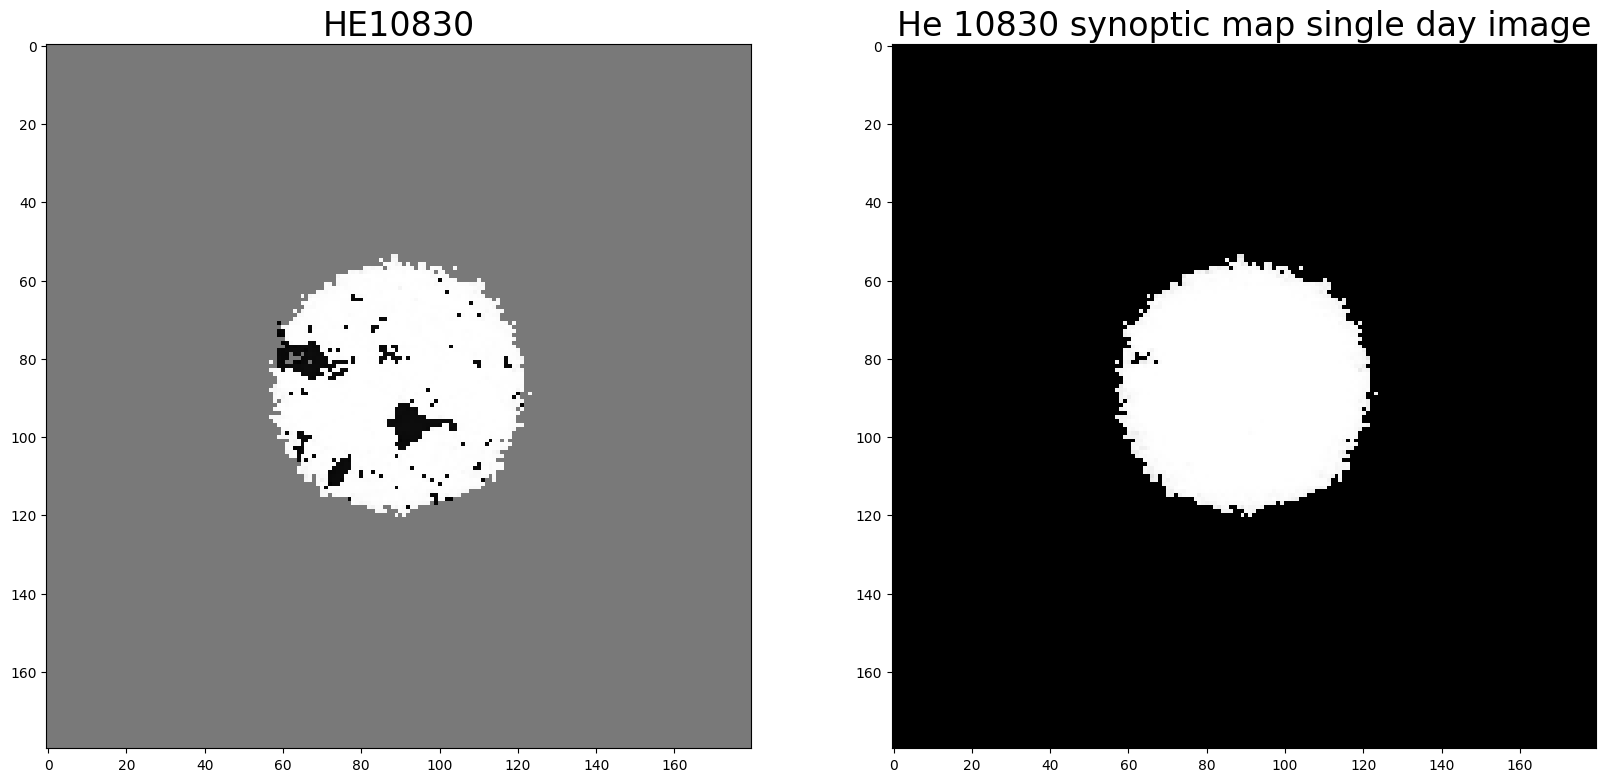

In [15]:
fits = '~/Desktop/out_solarstrm_data/' + 'svsm_e31lr_L3_20140626_1419.fts'
im_list = plot_detection.plot_raw_fits_content(
    fits, header_list=['IMTYPE', 'COMMENT2'],
    cmaps=[plt.cm.gray, plt.cm.gray, plt.cm.gray],
    print_header=True
)

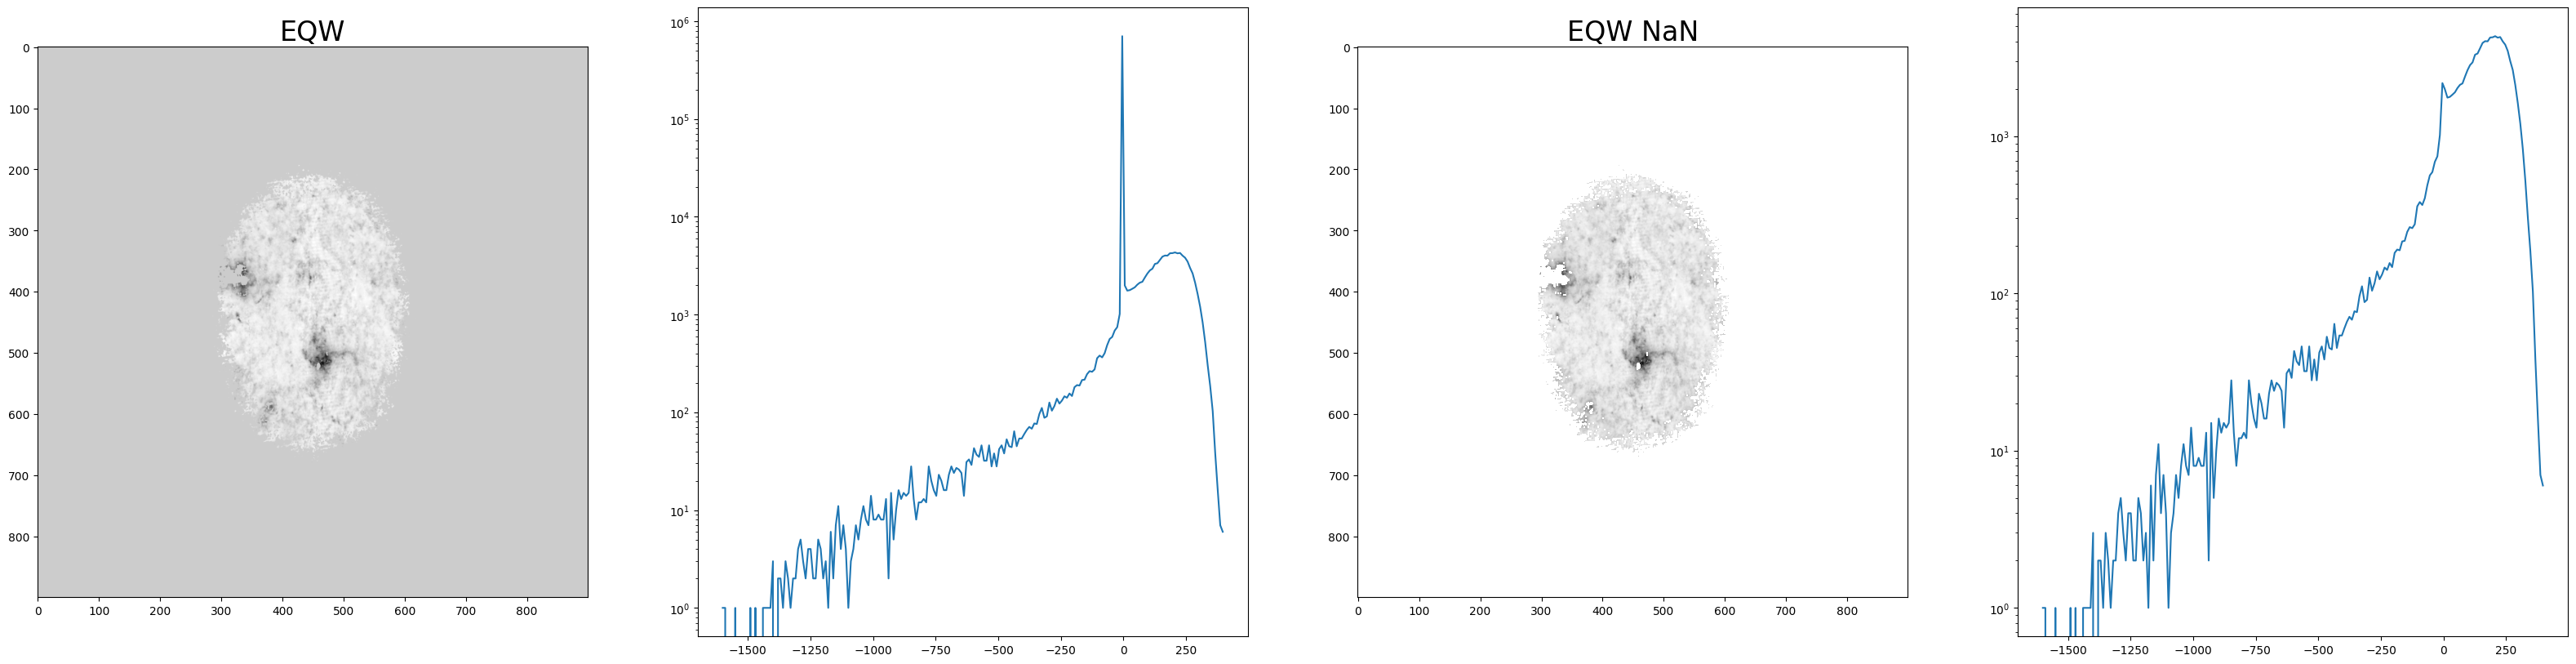

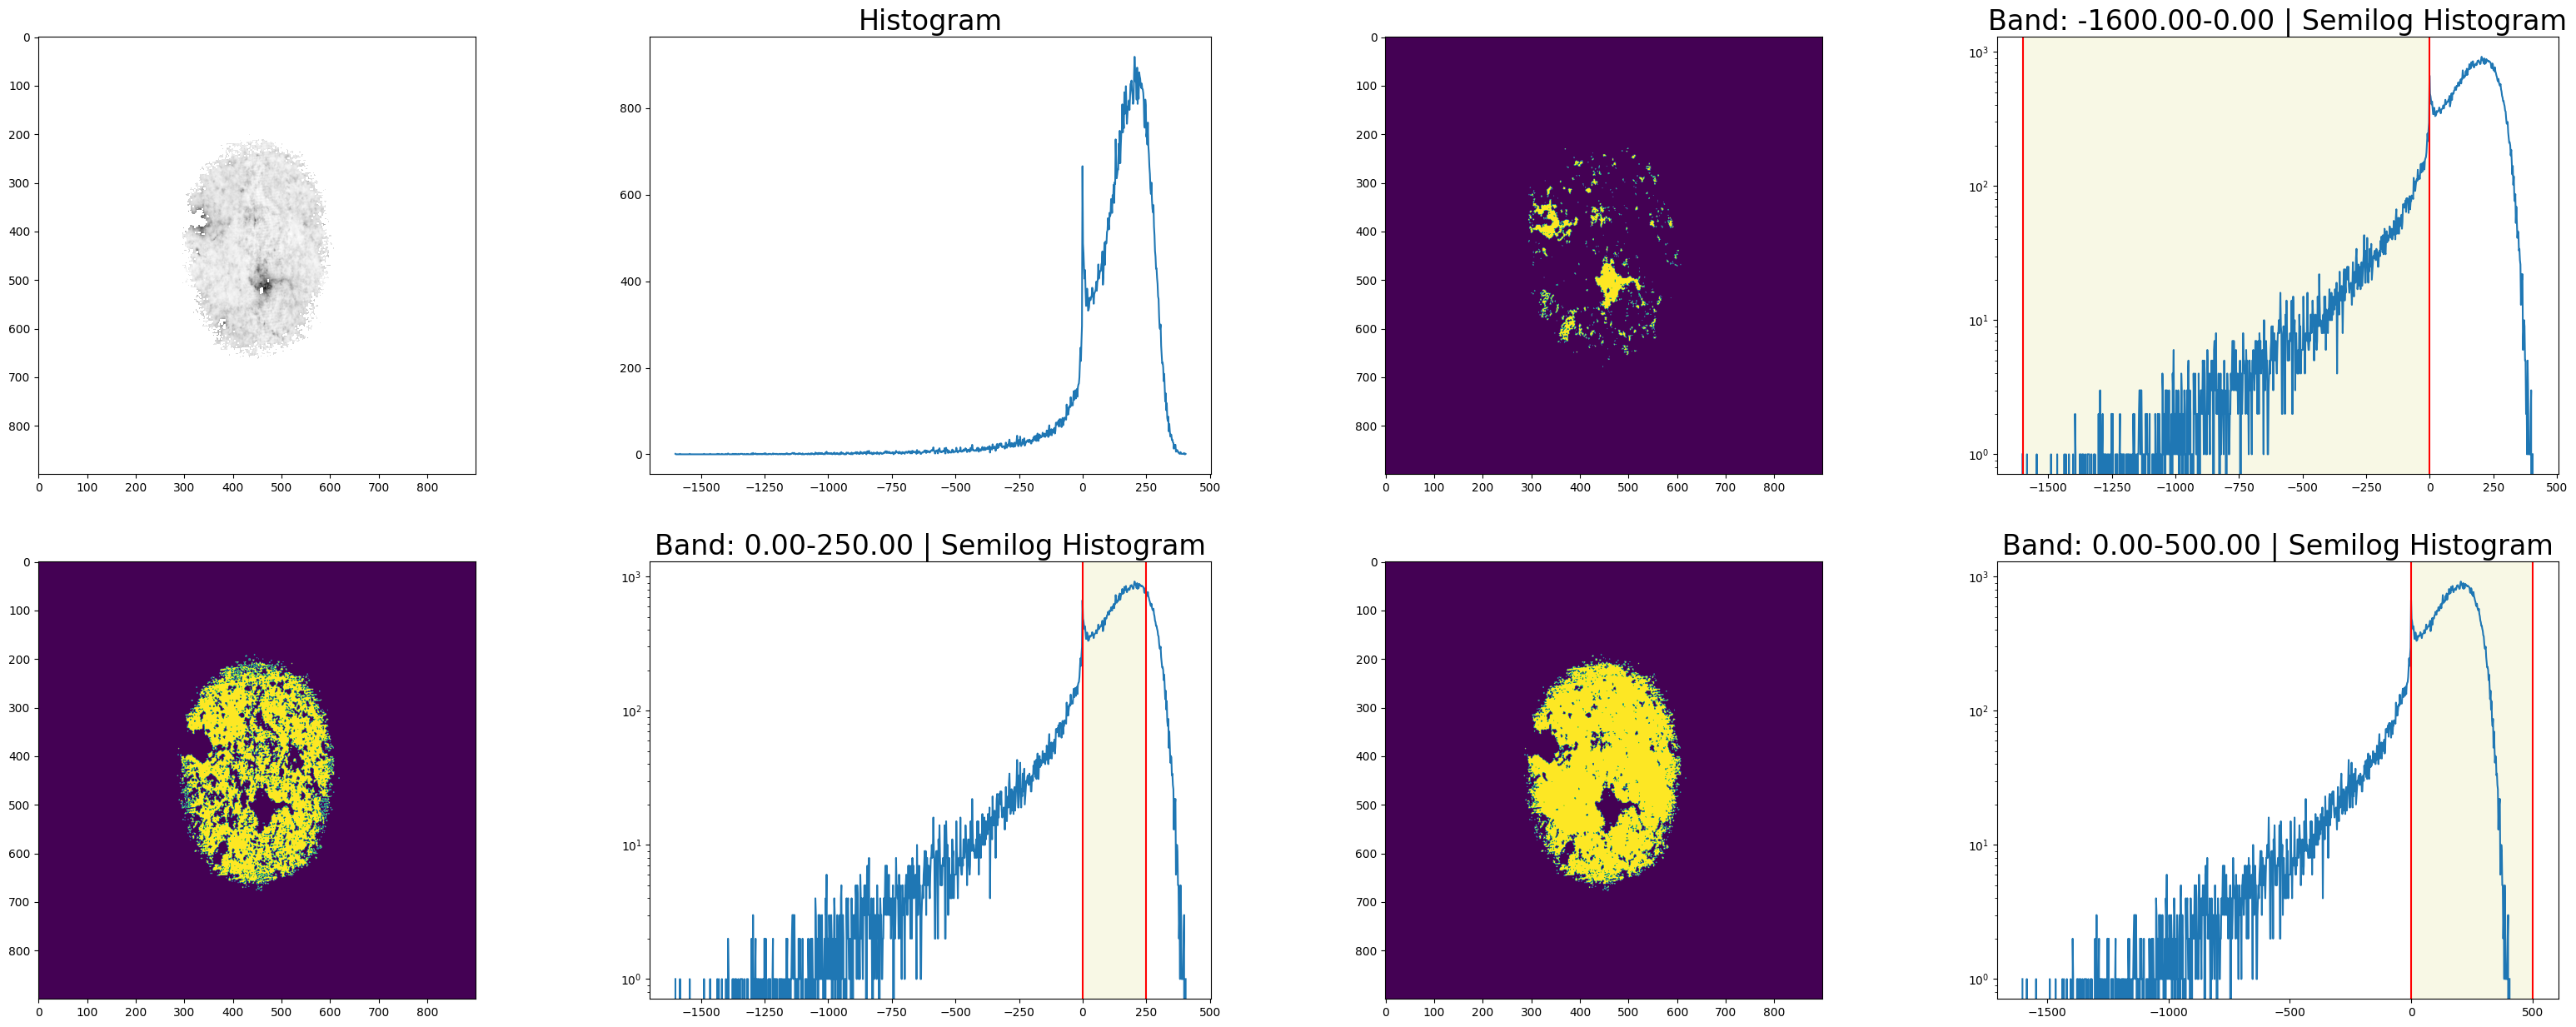

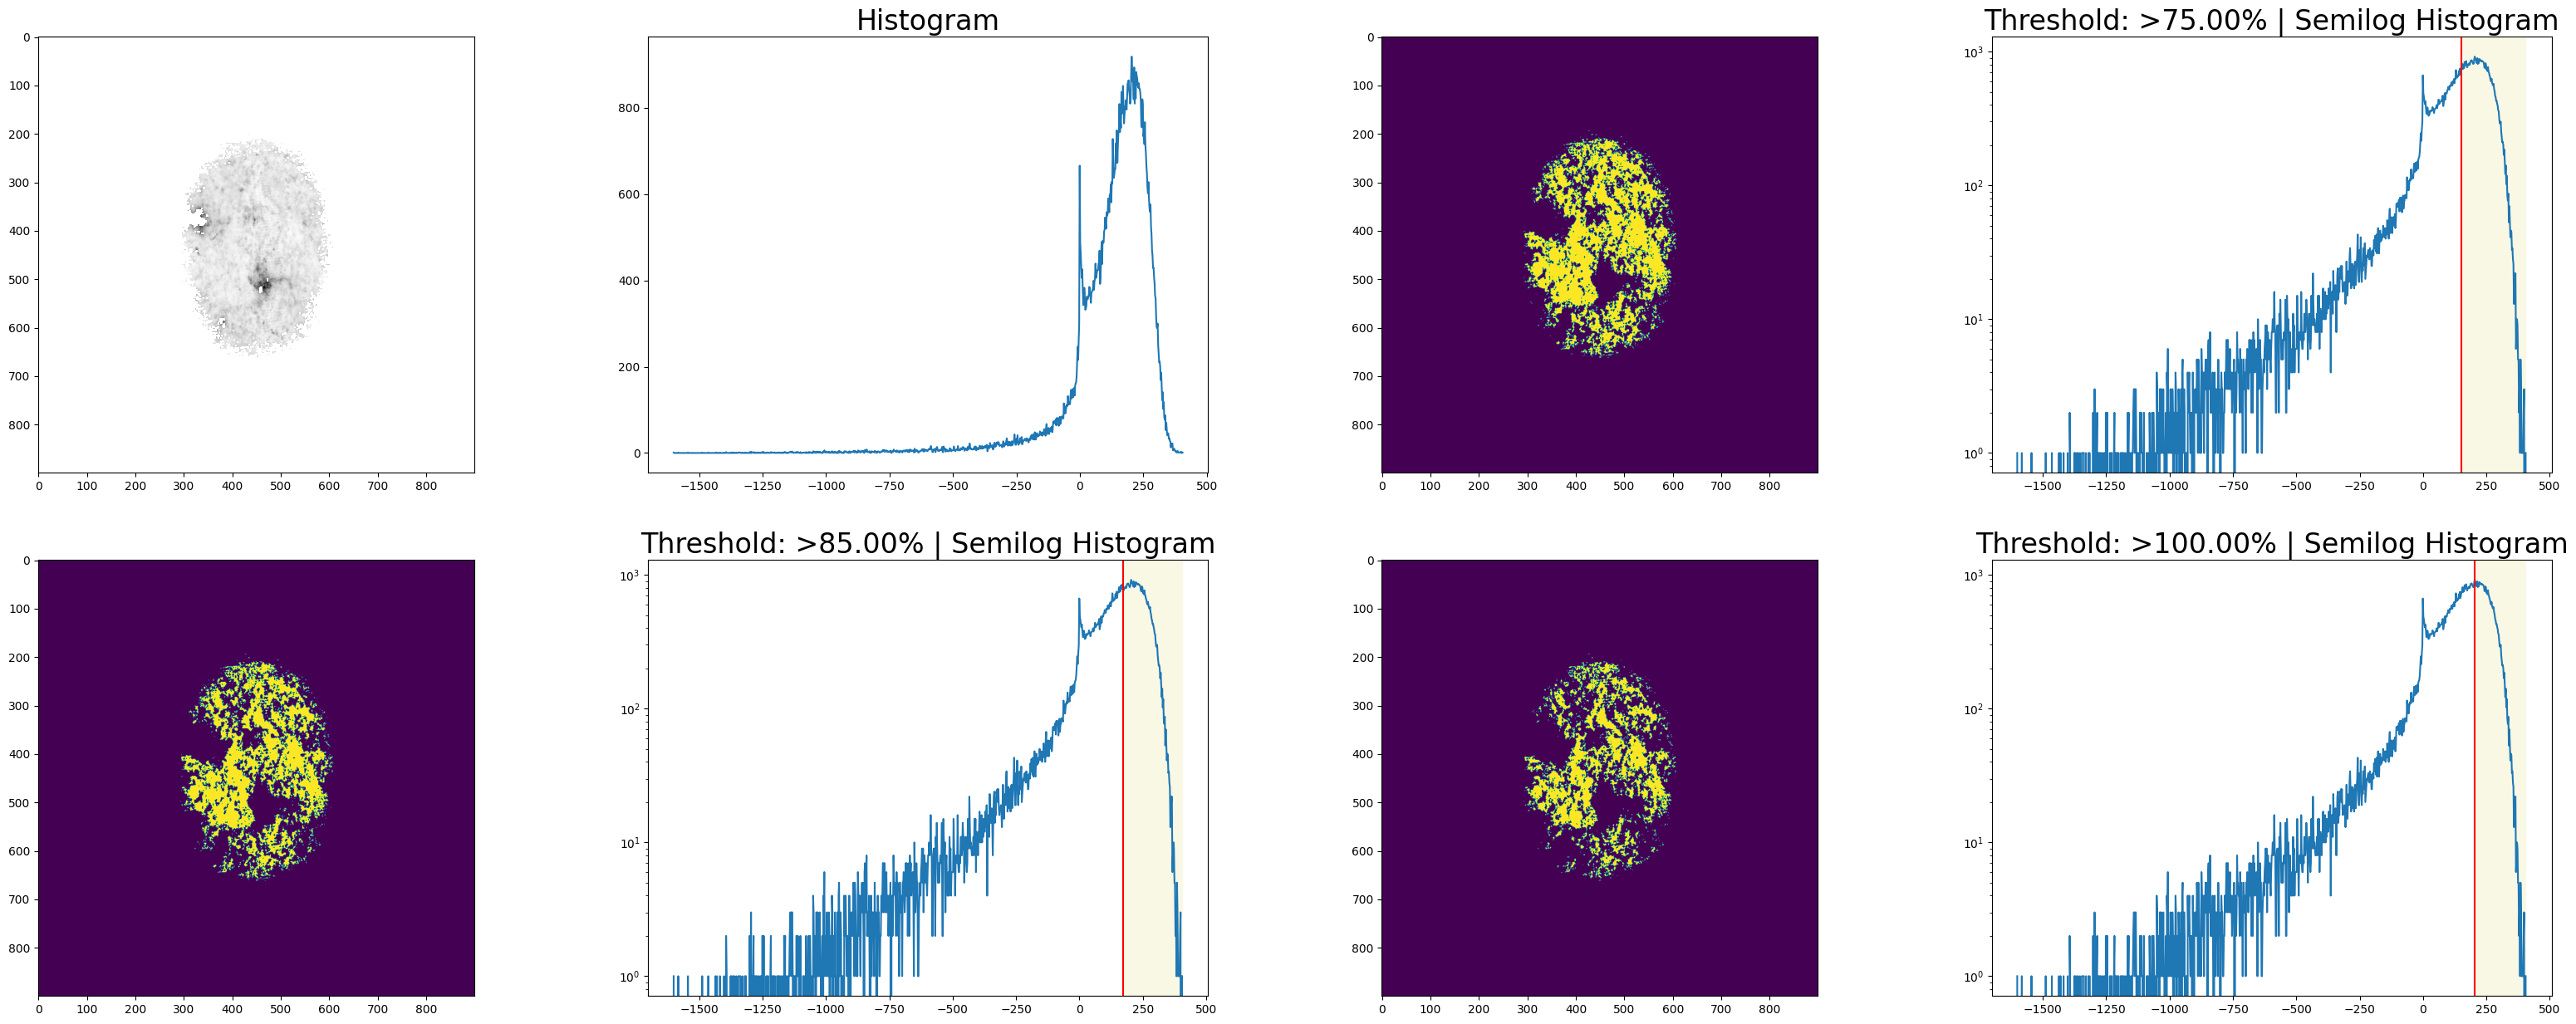

In [17]:
date_str = '2014_06_26__00_00'

raw_nso_eqw = NSO_EQW_DICT[date_str]
nso_eqw_nan = run_detection.pre_process_eqw_v0_1(raw_nso_eqw)[2]

titles = ['EQW', 'EQW NaN']
plot_detection.plot_hists(
    [raw_nso_eqw, nso_eqw_nan], titles, semilogy=True
)

lower_bounds = [-1600,  0,  0]
upper_bounds = [0,      250, 500]
plot_detection.plot_thresholds(
    nso_eqw_nan, bounds=[lower_bounds, upper_bounds], 
    bounds_as_percent=False, threshold_type='band'
)
plot_detection.plot_thresholds(
    nso_eqw_nan, bounds=[75, 85, 100], bounds_as_percent=True
)

### Merged Maps: **../merged/carr-daily/**
Carrington Rotation CH Map: **svsm_o31hr_B3_cr{RRRR}_{DDD}.fts.gz**
- 'Solar wind source high-res sine-latlon daily synoptic map'
- Produced by **create_crmap**
  - Args: 27 most recent disk CH maps, disk CH maps list

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0.2701779 , 0.27507168, 0.28002557, ..., 4.372018  , 4.369194  ,
         4.366314  ],
        [0.2701779 , 0.27507168, 0.28002557, ..., 4.372018  , 4.369194  ,
         4.366314  ],
        [0.2701779 , 0.27507168, 0.28002557, ..., 4.372018  , 4.369194  ,
         4.366314  ],
        ...,
        [0.2701779 , 0.27507168, 0.28002557, ..., 4.372018  , 4.369194  ,
         4.366314  ],
        [0.2701779 , 0.27507168, 0.28002557, ..., 4.372018  , 4.369194  ,
         4.366314  ],
        [0.2701779 , 0.27507168, 0.28002557, ..., 4.372018  , 4.369194  ,
         4.366314  ]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,


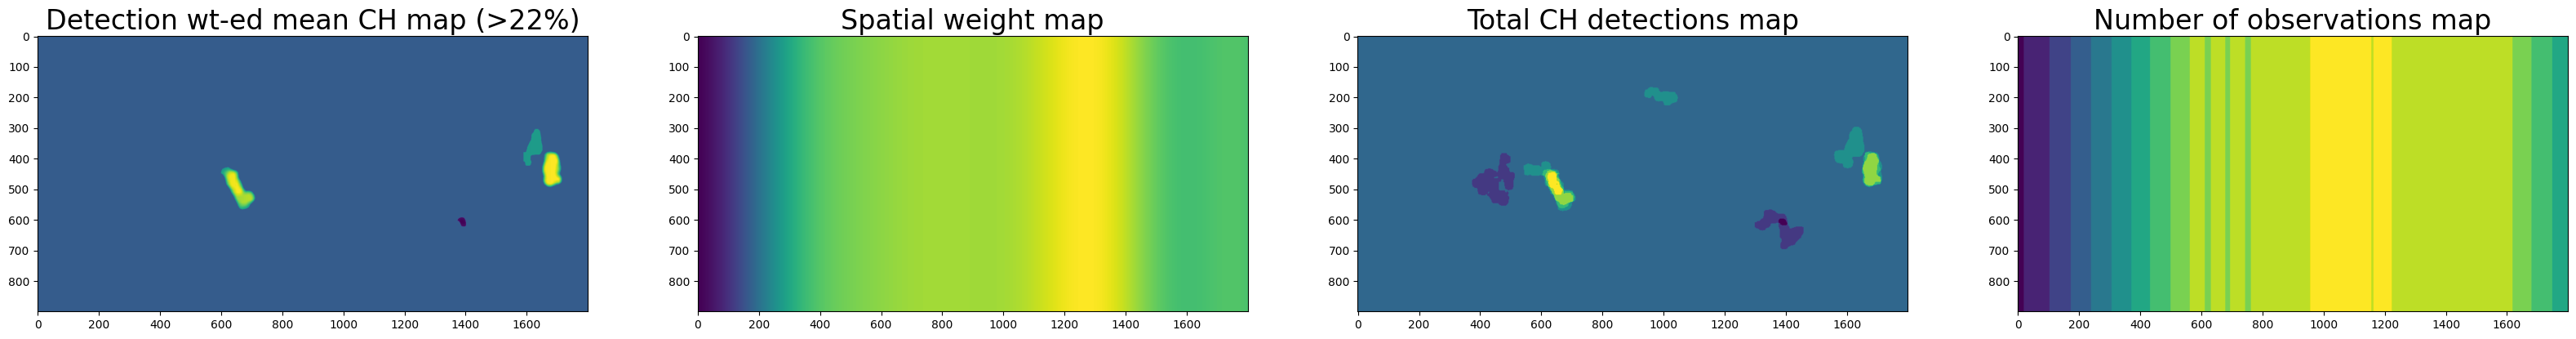

In [18]:
synoptic_ch_fits_path = NSO_MERGED_DIR + 'svsm_o31hr_B3_cr2152_275.fts'

plot_detection.plot_raw_fits_content(
    synoptic_ch_fits_path,
    # header_list=['DATE', 'CARR01', 'IMTYPE'],
    header_list=['IMGTYP01', 'IMGTYP02', 'IMGTYP03', 'IMGTYP04'],
    # print_header=True
)

## Algorithm on NSO EQW

In [ ]:
date_str = '2014_06_26__00_00'

raw_nso_eqw = NSO_EQW_DICT[date_str]
nso_eqw_nan = prepare_data.pre_process_eqw_v0_01(raw_nso_eqw)[2]

percent_of_peak_list = [80,85,90]
radius_list = [6]

ensemble_map, holes_mask_list, confidence_list = run_detection.get_ensemble(
    nso_eqw_nan, percent_of_peak_list, radius_list)

title_list = [f'{percent_of_peak:d}% of Histogram Peak | {radius:d}px Radius'
              for percent_of_peak in percent_of_peak_list
              for radius in radius_list]

plot_detection.plot_ensemble(
    nso_eqw_nan, ensemble_map, confidence_list, title_list, holes_mask_list
)

# Ensemble Maps

## Maps

Magnetogram & EUV

In [ ]:
overwrite = True
output_dir = ENSEMBLE_MAP_IMAGE_DIR + 'Full_Comparison/'
smooth_size_percent = 10

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

for euv_date_str in EUV_DATE_LIST:
    
    # Optionally overwrite existing files
    comparison_img_file = f'{output_dir}EUV{euv_date_str}.jpg'
    if os.path.isfile(comparison_img_file) and not overwrite:
        print((f'EUV {euv_date_str} full comparison already exists.'))
        continue

    he_date_str = prepare_data.get_latest_date_str(
        HE_DATE_LIST, selected_date_str=euv_date_str
    )
    mag_date_str = prepare_data.get_nearest_date_str(
        MAG_DATE_LIST, selected_date_str=he_date_str
    )
    
    # Extract He I observation
    he_map = prepare_data.get_solis_sunpy_map(ALL_HE_DIR + he_date_str + '.fts')
    if not he_map:
        print(f'{he_date_str} He I observation extraction failed.')
        continue
    
    mag_map = prepare_data.get_solis_sunpy_map(ALL_MAG_DIR + mag_date_str + '.fts')
    euv_map = sunpy.map.Map(ALL_EUV_DIR + euv_date_str + '.fts')

    # Process magnetogram
    smoothed_mag_map = prepare_data.get_smoothed_map(mag_map, smooth_size_percent)
    
    # Extract saved ensemble map array and convert to Sunpy map
    ensemble_file = f'{ENSEMBLE_MAP_SAVE_DIR}{he_date_str}_ensemble_map.npy'
    ensemble_map_data = np.load(ensemble_file, allow_pickle=True)[-1]
    ensemble_map = sunpy.map.Map(np.flipud(ensemble_map_data), he_map.meta)
    ensemble_map.plot_settings['cmap'] = matplotlib.colormaps['magma']
    
    fig = plt.figure(figsize=(24, 5))

    ax = fig.add_subplot(141, projection=he_map)
    he_map.plot(axes=ax, vmin=-100, vmax=100, title=he_date_str)

    ax = fig.add_subplot(142, projection=he_map)
    ensemble_map.plot(axes=ax, title='')
    
    ax = fig.add_subplot(143, projection=mag_map)
    mag_map.plot(axes=ax, vmin=-50, vmax=50, title=mag_date_str)
    plot_detection.plot_map_contours(ax, smoothed_mag_map)
    
    ax = fig.add_subplot(144, projection=euv_map)
    euv_map.plot(axes=ax, title=euv_date_str)
    
    plt.savefig(comparison_img_file)
    plt.close(fig)

    print(f'{euv_date_str} map comparison saved.')

Create Reprojected Magnetograms and Save to Files (Expensive computation)

In [42]:
overwrite = True
smooth_size_percent = 10

if not os.path.isdir(REPROJECT_MAG_SAVE_DIR):
    os.makedirs(REPROJECT_MAG_SAVE_DIR)

for he_date_str in HE_DATE_LIST:

    mag_date_str = prepare_data.get_nearest_date_str(
        MAG_DATE_LIST, selected_date_str=he_date_str
    )
    
    fits_file_name = f'{REPROJECT_MAG_SAVE_DIR}Mag{mag_date_str}_He{he_date_str}'
    reprojected_fits_file = f'{fits_file_name}.fits'
    reprojected_smooth_fits_file = f'{fits_file_name}_smooth.fits'
    
    # Optionally overwrite existing files
    if os.path.isfile(reprojected_fits_file):
        if overwrite:
            os.remove(reprojected_fits_file)
        else:
            print((f'{mag_date_str} magnetogram reprojected '
                   + f'to {he_date_str} already exists.'))
            continue
    
    if os.path.isfile(reprojected_smooth_fits_file):
        if overwrite:
            os.remove(reprojected_smooth_fits_file)
        else:
            print((f'{mag_date_str} magnetogram reprojected '
                   + f'to {he_date_str} already exists.'))
            continue
    
    # Extract He I observation
    he_map = prepare_data.get_solis_sunpy_map(ALL_HE_DIR + he_date_str + '.fts')
    if not he_map:
        print(f'{he_date_str} He I observation extraction failed.')
        continue
    
    # Extract Magnetogram observation
    mag_map = prepare_data.get_solis_sunpy_map(ALL_MAG_DIR + mag_date_str + '.fts')

    # Process magnetogram
    smoothed_map = prepare_data.get_smoothed_map(mag_map, smooth_size_percent)
    reprojected_mag_map = prepare_data.get_reprojected_map(
        input_map=mag_map, target_map=he_map
    )
    reprojected_smooth_map = prepare_data.get_reprojected_map(
        input_map=smoothed_map, target_map=he_map
    )
    
    # Save to FITS files
    reprojected_mag_map.save(reprojected_fits_file)
    reprojected_smooth_map.save(f'{fits_file_name}_smooth.fits')
    print(f'{mag_date_str} magnetogram reprojected to {he_date_str} maps saved.')

2012_06_09__17_34 magnetogram reprojected to 2012_06_09__19_20 maps saved.
2012_06_10__15_59 magnetogram reprojected to 2012_06_10__17_44 maps saved.
2012_06_11__16_12 magnetogram reprojected to 2012_06_11__18_01 maps saved.
2012_06_12__15_11 magnetogram reprojected to 2012_06_12__16_59 maps saved.
2012_06_13__15_04 magnetogram reprojected to 2012_06_13__17_20 maps saved.
2012_06_14__14_53 magnetogram reprojected to 2012_06_14__17_41 maps saved.
2012_06_15__15_12 magnetogram reprojected to 2012_06_15__17_01 maps saved.
2012_06_16__17_36 magnetogram reprojected to 2012_06_16__19_29 maps saved.
2012_06_17__16_12 magnetogram reprojected to 2012_06_17__18_07 maps saved.
2012_06_18__15_25 magnetogram reprojected to 2012_06_18__17_16 maps saved.
2012_06_19__16_07 magnetogram reprojected to 2012_06_19__17_56 maps saved.
2012_06_20__16_50 magnetogram reprojected to 2012_06_20__19_06 maps saved.
2012_06_21__15_47 magnetogram reprojected to 2012_06_21__18_53 maps saved.
2012_06_22__15_59 magneto

Magnetogram Contours

In [41]:
output_dir = ENSEMBLE_MAP_IMAGE_DIR + 'Mag_Comparison/'

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

for he_date_str in HE_DATE_LIST:

    mag_date_str = prepare_data.get_nearest_date_str(
        MAG_DATE_LIST, selected_date_str=he_date_str
    )

    # Extract He I observation
    he_map = prepare_data.get_solis_sunpy_map(ALL_HE_DIR + he_date_str + '.fts')
    if not he_map:
        print(f'{he_date_str} He I observation extraction failed.')
        continue

    # Extract saved processed magnetograms
    mag_fits_name = f'{REPROJECT_MAG_SAVE_DIR}Mag{mag_date_str}_He{he_date_str}'
    reprojected_fits_file = f'{mag_fits_name}.fits'
    reprojected_smooth_fits_file = f'{mag_fits_name}_smooth.fits'
    reprojected_mag_map = sunpy.map.Map(reprojected_fits_file)
    reprojected_smooth_map = sunpy.map.Map(reprojected_smooth_fits_file)
    # reprojected_smooth_map = sunpy.map.Map(np.fliplr(reprojected_smooth_map.data), reprojected_smooth_map.meta)

    # Extract saved ensemble map array and convert to Sunpy map
    ensemble_file = f'{ENSEMBLE_MAP_SAVE_DIR}{he_date_str}_ensemble_map.npy'
    ensemble_map_data = np.load(ensemble_file, allow_pickle=True)[-1]
    ensemble_map = sunpy.map.Map(np.flipud(ensemble_map_data), he_map.meta)
    ensemble_map.plot_settings['cmap'] = matplotlib.colormaps['magma']

    fig = plt.figure(figsize=(18, 5))

    ax = fig.add_subplot(131, projection=he_map)
    he_map.plot(axes=ax, vmin=-100, vmax=100, title=he_date_str)

    ax = fig.add_subplot(132, projection=he_map)
    ensemble_map.plot(axes=ax, title='')
    plot_detection.plot_map_contours(ax, reprojected_smooth_map)

    ax = fig.add_subplot(133, projection=he_map)
    reprojected_mag_map.plot(axes=ax, vmin=-50, vmax=50, title=mag_date_str)
    plot_detection.plot_map_contours(ax, reprojected_smooth_map)

    plt.savefig(f'{output_dir}He{he_date_str}.jpg')
    plt.close(fig)

    print(f'{he_date_str} map comparison saved')

2012_06_01__17_15 map comparison saved
2012_06_02__21_21 map comparison saved
2012_06_04__17_18 map comparison saved
2012_06_05__17_16 map comparison saved
2012_06_06__19_11 map comparison saved
2012_06_07__18_10 map comparison saved
2012_06_08__19_51 map comparison saved


ValueError: Did not find any files at assets/Output/Reprojected_Mag/Mag2012_06_09__17_34_He2012_06_09__19_20.fits

Ensemble Magnetic Contours & EUV 

In [23]:
overwrite = True
output_dir = ENSEMBLE_MAP_IMAGE_DIR + 'EUV_Comparison/'

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

for euv_date_str in EUV_DATE_LIST:
    
    # Optionally overwrite existing files
    comparison_img_file = f'{output_dir}EUV{euv_date_str}.jpg'
    if os.path.isfile(comparison_img_file) and not overwrite:
        print((f'EUV {euv_date_str} comparison already exists.'))
        continue

    he_date_str = prepare_data.get_latest_date_str(
        HE_DATE_LIST, selected_date_str=euv_date_str
    )
    mag_date_str = prepare_data.get_nearest_date_str(
        MAG_DATE_LIST, selected_date_str=he_date_str
    )
    
    # Extract He I observation
    he_map = prepare_data.get_solis_sunpy_map(ALL_HE_DIR + he_date_str + '.fts')
    if not he_map:
        print(f'{he_date_str} He I observation extraction failed.')
        continue
    
    euv_map = sunpy.map.Map(ALL_EUV_DIR + euv_date_str + '.fts')
    
    # Extract saved ensemble map array and convert to Sunpy map
    ensemble_file = f'{ENSEMBLE_MAP_SAVE_DIR}{he_date_str}_ensemble_map.npy'
    ensemble_map_data = np.load(ensemble_file, allow_pickle=True)[-1]
    ensemble_map = sunpy.map.Map(np.flipud(ensemble_map_data), he_map.meta)
    ensemble_map.plot_settings['cmap'] = matplotlib.colormaps['magma']    

    # Extract saved processed magnetogram
    mag_fits_name = f'{REPROJECT_MAG_SAVE_DIR}Mag{mag_date_str}_He{he_date_str}'
    reprojected_smooth_fits_file = f'{mag_fits_name}_smooth.fits'
    reprojected_smooth_map = sunpy.map.Map(reprojected_smooth_fits_file)
    
    fig = plt.figure(figsize=(18, 5))
    
    # Plot He observation
    ax = fig.add_subplot(131, projection=he_map)
    he_map.plot(axes=ax, vmin=-100, vmax=100, title=he_date_str)
    
    # Plot ensemble map with overlayed neutral lines
    ax = fig.add_subplot(132, projection=he_map)
    ensemble_map.plot(axes=ax, title='')
    plot_detection.plot_map_contours(ax, reprojected_smooth_map)
    
    # Plot EUV observation
    ax = fig.add_subplot(133, projection=euv_map)
    euv_map.plot(axes=ax, title=euv_date_str)
    
    # Save plot
    plt.savefig(comparison_img_file)
    plt.close(fig)
    print(f'{euv_date_str} map comparison saved.')

2012_06_01__16_15 map comparison saved.


## Outcomes

Outcomes vs Time

In [30]:
confidence_level_list = [1, 50, 75, 95]
num_ch_df, area_percent_df, area_df, px_percent_df = run_detection.get_outcome_dfs(
    HE_DATE_LIST, confidence_level_list, ALL_HE_DIR, ENSEMBLE_MAP_SAVE_DIR
)

In [33]:
overwrite = True
region_num_settings = (
    ENSEMBLE_MAP_IMAGE_DIR + 'Region_Number/',
    num_ch_df, 'viridis', 'Detected CH Number'
)
px_percent_settings = (
    ENSEMBLE_MAP_IMAGE_DIR + 'EUV_Px_Percentage/',
    px_percent_df, 'plasma', 'Detected Pixel Percentage (%)'
)
area_percent_settings = (
    ENSEMBLE_MAP_IMAGE_DIR + 'EUV_Area_Percentage/',
    area_percent_df, 'plasma', 'Detected Area Percentage (%)'
)
area_settings = (
    ENSEMBLE_MAP_IMAGE_DIR + 'EUV_Area/',
    area_df, 'plasma', 'Detected Area (Mm^2)'
)
output_dir, outcome_df, cmap, ylabel = area_percent_settings

In [34]:
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

for euv_date_str in EUV_DATE_LIST:
    
    # Optionally overwrite existing files
    comparison_img_file = f'{output_dir}EUV{euv_date_str}.jpg'
    if os.path.isfile(comparison_img_file) and not overwrite:
        print((f'EUV {euv_date_str} comparison already exists.'))
        continue

    he_date_str = prepare_data.get_latest_date_str(
        HE_DATE_LIST, selected_date_str=euv_date_str
    )
    mag_date_str = prepare_data.get_nearest_date_str(
        MAG_DATE_LIST, selected_date_str=he_date_str
    )
    
    # Extract He I observation
    he_map = prepare_data.get_solis_sunpy_map(ALL_HE_DIR + he_date_str + '.fts')
    if not he_map:
        print(f'{he_date_str} He I observation extraction failed.')
        continue
    
    euv_map = sunpy.map.Map(ALL_EUV_DIR + euv_date_str + '.fts')
    
    # Extract saved ensemble map array and convert to Sunpy map
    ensemble_file = f'{ENSEMBLE_MAP_SAVE_DIR}{he_date_str}_ensemble_map.npy'
    ensemble_map_data = np.load(ensemble_file, allow_pickle=True)[-1]
    ensemble_map = sunpy.map.Map(np.flipud(ensemble_map_data), he_map.meta)
    ensemble_map.plot_settings['cmap'] = matplotlib.colormaps['magma']

    # Extract saved processed magnetogram
    mag_fits_name = f'{REPROJECT_MAG_SAVE_DIR}Mag{mag_date_str}_He{he_date_str}'
    reprojected_smooth_fits_file = f'{mag_fits_name}_smooth.fits'
    reprojected_smooth_map = sunpy.map.Map(reprojected_smooth_fits_file)
    
    fig = plt.figure(figsize=(18, 10))
    
    # Plot He observation
    ax = fig.add_subplot(231, projection=he_map)
    he_map.plot(axes=ax, vmin=-100, vmax=100, title=he_date_str)
    
    # Plot ensemble map with overlayed neutral lines
    ax = fig.add_subplot(232, projection=he_map)
    ensemble_map.plot(axes=ax, title='')
    plot_detection.plot_map_contours(ax, reprojected_smooth_map)
    
    # Plot EUV observation
    ax = fig.add_subplot(233, projection=euv_map)
    euv_map.plot(axes=ax, title=euv_date_str)
    
    ax = fig.add_subplot(2, 3, (4, 6))
    plot_detection.plot_outcome_vs_time(
        ax, outcome_df, he_date_str, cmap, ylabel)
    
    # Save plot
    plt.savefig(comparison_img_file)
    plt.close(fig)
    print(f'{euv_date_str} map comparison saved.')

2012_06_01__16_15 map comparison saved.
2012_06_02__20_21 map comparison saved.
2012_06_03__13_00 map comparison saved.
2012_06_04__16_18 map comparison saved.
2012_06_05__16_16 map comparison saved.
2012_06_06__18_11 map comparison saved.
2012_06_07__17_10 map comparison saved.
2012_06_08__18_51 map comparison saved.
2012_06_09__18_20 map comparison saved.
2012_06_10__16_44 map comparison saved.
2012_06_11__17_01 map comparison saved.
2012_06_12__15_59 map comparison saved.
2012_06_13__16_20 map comparison saved.
2012_06_14__16_41 map comparison saved.
2012_06_15__16_01 map comparison saved.
2012_06_16__18_29 map comparison saved.
2012_06_17__17_07 map comparison saved.
2012_06_18__16_16 map comparison saved.
2012_06_19__16_56 map comparison saved.
2012_06_20__17_06 map comparison saved.
2012_06_21__17_53 map comparison saved.
2012_06_22__17_13 map comparison saved.
2012_06_23__17_34 map comparison saved.
2012_06_24__13_00 map comparison saved.
2012_06_25__15_50 map comparison saved.


Outcomes vs Methods

In [36]:
confidence_level_list = [1, 50, 75, 95]
area_df_by_method_list = []
mad_by_conf_by_method_list = []
norm_mad_by_conf_by_method_list = []

for ensemble_maps_dir in ['Ensemble_Maps_v0_3/', 'Band_Pass/',
                          'Rescale/', 'Rescale_Center/']:
    ensemble_maps_save_dir = OUTPUT_DIR + ensemble_maps_dir + 'Ensemble_Map_Files/'
    
    area_df = run_detection.get_outcome_dfs(
        HE_DATE_LIST, confidence_level_list, ALL_HE_DIR, ensemble_maps_save_dir
    )[2]
    area_df_by_method_list.append(area_df)
    mad_by_confidences, norm_mad_by_confidences = run_detection.get_mad_by_confidences(
        area_df, confidence_level_list
    )
    mad_by_conf_by_method_list.append(mad_by_confidences)
    norm_mad_by_conf_by_method_list.append(norm_mad_by_confidences)

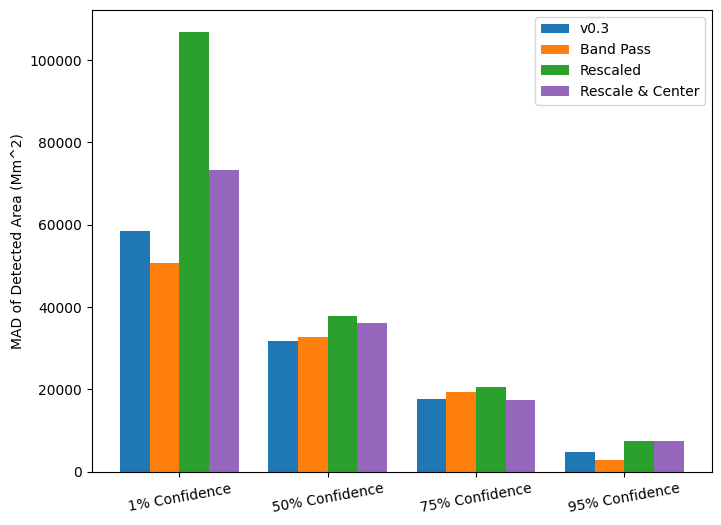

In [42]:
x_ticks = np.arange(len(confidence_level_list))
confidence_label_list = [
    f'{confidence_level}% Confidence'
    for confidence_level in confidence_level_list
]

plt.figure(1, figsize=(8,6))

plt.bar(x_ticks - 0.3, mad_by_conf_by_method_list[0], width=0.2, label='v0.3')
plt.bar(x_ticks - 0.1, mad_by_conf_by_method_list[1], width=0.2, label='Band Pass')
plt.bar(x_ticks + 0.1, mad_by_conf_by_method_list[2], width=0.2, label='Rescaled')
plt.bar(x_ticks + 0.3, mad_by_conf_by_method_list[3], width=0.2,
        label='Rescale & Center', color='C4')
plt.xticks(x_ticks, confidence_label_list, rotation=10)
plt.ylabel(f'MAD of Detected Area (Mm^2)')
plt.legend()

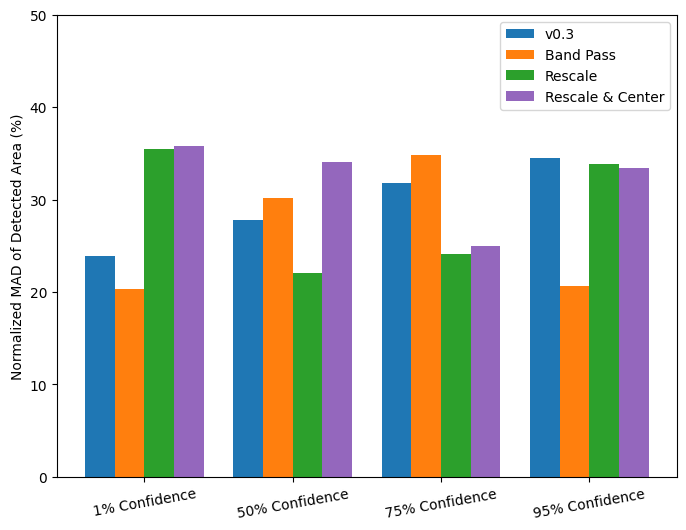

In [43]:
x_ticks = np.arange(len(confidence_level_list))
confidence_label_list = [
    f'{confidence_level}% Confidence'
    for confidence_level in confidence_level_list
]

plt.figure(1, figsize=(8,6))

plt.bar(x_ticks - 0.3, norm_mad_by_conf_by_method_list[0], width=0.2, label='v0.3')
plt.bar(x_ticks - 0.1, norm_mad_by_conf_by_method_list[1], width=0.2, label='Band Pass')
plt.bar(x_ticks + 0.1, norm_mad_by_conf_by_method_list[2], width=0.2, label='Rescale')
plt.bar(x_ticks + 0.3, norm_mad_by_conf_by_method_list[3], width=0.2,
        label='Rescale & Center', color='C4')
plt.xticks(x_ticks, confidence_label_list, rotation=10)
plt.ylim([0, 50])
plt.ylabel(f'Normalized MAD of Detected Area (%)')
plt.legend()

## Write Images to Video

In [35]:
run_detection.write_ensemble_video(output_dir, fps=2)

Moviepy - Building video assets/Output/Rescale_Center/2012_06/EUV_Area_Percentage/ensemble_vid_2fps.mp4.
Moviepy - Writing video assets/Output/Rescale_Center/2012_06/EUV_Area_Percentage/ensemble_vid_2fps.mp4



Moviepy - Done !
Moviepy - video ready assets/Output/Rescale_Center/2012_06/EUV_Area_Percentage/ensemble_vid_2fps.mp4
